# PHYSICAL ACTIVITY MONITORING WITH IMU

## CONTENTS
---
### Section 1
1. Overview
2. Data Collection
3. Data Cleaning
4. Exploratory Data Analysis
 - 4.1. Heartrate Analysis
 - 4.2. Subject Analysis
 - 4.3. Temperature Analysis
 - 4.4. Sensor Analysis 
 - 4.5. Data Splitting
 - 4.6. Correlation
 - 4.7. Preprocessing
### Section 2 
5. Hypothesis Testing
 - 5.1. Hypothesis 1
 - 5.2. Hypothesis 2
### Section 3 
6. Modelling
7. Interpretation
8. Summary
9. References

## 1. OVERVIEW

The dataset utilised for this report is PAMAP2, an activity monitoring dataset that contains data from 18 distinct physical activities (such as walking, cycling, ironing, etc) completed by 9 different subjects — eight men and one woman — wearing 3 inertial measurement units and a heart rate monitor.

This report will leverage PAMAP2 dataset to derive practical knowledge that can be used for activity recognition and intensity estimation, while developing and applying algorithms for data processing, feature extraction and classification. It would also provide insights that can enable the creation of a software and/or hardware for fitness tracking.
This assignment has three objectives, which are as follows:

> 1) Conduct in-depth exploratory data analysis and manage missing or contaminated data correctly.

> 2) Develop and test at least one hypothesis for a relationship between a single pair of attributes.

> 3) Develop and test at least one model which uses multiple attributes to make predictions.

The objectives are addressed in this report sequentially in the order in which they have been listed. The contents have been grouped into sections, each representing steps taken to address the objective of this report. ie: Section 1 contents addresses the first objective - Exploratory Data Analysis, Section 2 contents addresses the second objective - Hypothesis Testing and Section 3 addresses the third objective - Data Modelling.

## 2. DATA COLLECTION

The activity monitoring data for the various subjects are loaded into a dataframe in this stage for cleaning and preprocessing.
I first of all import all necessary libraries to be used for this analysis before proceeding to import the data for cleaning

In [1]:
# import necessary libraries

import os
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np
from scipy import stats
from scipy import integrate
from IPython.display import HTML, display
from scipy.stats import norm
from scipy.stats import t as the
from sklearn.svm import SVC
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedShuffleSplit
from sklearn.metrics import precision_score,recall_score, f1_score, confusion_matrix,roc_auc_score,roc_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from fnmatch import fnmatch
import math
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 70)
%matplotlib inline

Here, I set up metadata and global variables required for extracting and processing the data.

In [2]:
# Load data

subject_id = []
file_names = []

pattern = '*.dat'
for path, subdirs, files in os.walk(
    "Protocol", topdown=True):
  for name in files:
    if fnmatch(name, pattern):
      subject_id.append(int(name[-5]))
      file_name = os.path.join(path, name)
      file_names.append(file_name)

activities = {0: 'transient',
              1: 'lying',
              2: 'sitting',
              3: 'standing',
              4: 'walking',
              5: 'running',
              6: 'cycling',
              7: 'Nordic_walking',
              9: 'watching_TV',
              10: 'computer_work',
              11: 'car driving',
              12: 'ascending_stairs',
              13: 'descending_stairs',
              16: 'vacuum_cleaning',
              17: 'ironing',
              18: 'folding_laundry',
              19: 'house_cleaning',
              20: 'playing_soccer',
              24: 'rope_jumping' }

all_columns = ["timestamp", "activityID","heartrate",'handTemperature',
               'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handAcc6_1',
               'handAcc6_2', 'handAcc6_3', 'handGyro1', 'handGyro2',
               'handGyro3', 'handMagne1', 'handMagne2', 'handMagne3',
               'handOrientation1', 'handOrientation2', 'handOrientation3',
               'handOrientation4', 'chestTemperature', 'chestAcc16_1',
               'chestAcc16_2', 'chestAcc16_3', 'chestAcc6_1', 'chestAcc6_2',
               'chestAcc6_3', 'chestGyro1', 'chestGyro2', 'chestGyro3',
               'chestMagne1', 'chestMagne2', 'chestMagne3', 'chestOrientation1',
               'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
               'ankleTemperature', 'ankleAcc16_1', 'ankleAcc16_2',
               'ankleAcc16_3', 'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3',
               'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 'ankleMagne1',
               'ankleMagne2', 'ankleMagne3', 'ankleOrientation1',
               'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']


In [3]:
# Save data in pandas dataframe

dataset = pd.DataFrame()
for file, subject_id in zip(file_names, subject_id):
  df = pd.read_table(file, header=None, sep='\s+')
  df.columns = all_columns
  df['subject_id'] = subject_id
  dataset = pd.concat([dataset, df], ignore_index=True)

In [4]:
# Quick glance at the dataset

dataset.tail(5)

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,handGyro3,handMagne1,handMagne2,handMagne3,handOrientation1,handOrientation2,handOrientation3,handOrientation4,chestTemperature,chestAcc16_1,chestAcc16_2,chestAcc16_3,chestAcc6_1,chestAcc6_2,chestAcc6_3,chestGyro1,chestGyro2,chestGyro3,chestMagne1,chestMagne2,chestMagne3,chestOrientation1,chestOrientation2,chestOrientation3,chestOrientation4,ankleTemperature,ankleAcc16_1,ankleAcc16_2,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
2872528,100.19,0,NaN,25.1875,-4.71493,10.22250,4.66893,-5.04654,9.94944,4.50736,1.78406,0.087985,0.934673,21.1701,-35.3878,-34.0443,0.558630,-0.593878,0.292228,0.499844,32.375,2.92664,10.21030,-0.983335,3.12563,10.62120,0.642058,-0.034671,-0.222172,-0.191336,15.5991,-40.9116,14.9966,0.625172,-0.760781,-0.039443,-0.169753,31.5,9.38737,-0.565040,-3.27370,9.09401,-0.228554,-2.68770,-0.037788,-0.062676,-0.127084,-46.5153,3.58240,-0.035995,0.598531,0.033615,0.799791,-0.031075,9
2872529,100.20,0,NaN,25.1875,-4.95932,10.37130,4.12594,-4.96890,10.29620,4.43102,1.47521,-0.028917,0.806540,20.7931,-34.9954,-34.1772,0.555545,-0.596490,0.299264,0.495995,32.375,2.72281,9.37125,-2.649300,2.83965,9.86963,-1.111460,-0.068016,-0.217669,-0.211320,15.3637,-41.2887,14.0101,0.625592,-0.760751,-0.039538,-0.168312,31.5,9.45875,-1.020820,-3.30873,9.27291,-0.607010,-2.99014,-0.068904,-0.027006,-0.089808,-45.7474,3.54453,0.108583,0.598428,0.033012,0.799933,-0.030018,9
2872530,100.21,0,NaN,25.1875,-4.93997,9.83615,3.70468,-5.04613,10.35690,4.14405,1.29099,-0.155493,0.762446,20.6763,-36.6013,-32.4612,0.553254,-0.598417,0.305463,0.492442,32.375,2.65722,9.07285,-2.262310,2.64813,9.29824,-2.351200,-0.077873,-0.152311,-0.237024,15.8809,-41.4368,14.0146,0.625921,-0.760792,-0.039435,-0.166927,31.5,9.57580,-0.528578,-3.23340,9.43813,-0.697724,-2.99072,-0.070888,-0.038024,-0.064709,-46.3997,4.22078,0.105504,0.598233,0.033172,0.800095,-0.029416,9
2872531,100.22,0,NaN,25.1875,-4.64941,9.11129,3.51904,-5.06854,9.75268,3.87359,1.20794,-0.311214,0.748814,20.5408,-35.8494,-32.3342,0.551068,-0.599876,0.311399,0.489390,32.375,2.61289,8.88341,-2.456100,2.55741,9.02648,-2.139860,0.138759,0.027529,-0.333854,15.6351,-42.2015,14.0172,0.625555,-0.761266,-0.040453,-0.165888,31.5,9.49894,-0.489493,-3.31161,9.49875,-0.576563,-2.87035,0.018961,-0.025796,-0.064357,-46.5282,4.48593,0.530240,0.598116,0.033427,0.800180,-0.029208,9
2872532,100.23,0,161.0,25.1875,-4.09726,8.15642,3.29961,-4.73244,8.82870,3.54305,1.40417,-0.396125,0.728581,20.3057,-37.3255,-31.5374,0.548065,-0.601715,0.317869,0.486336,32.375,2.77196,9.22311,-2.260720,2.52647,8.90583,-2.155140,0.250226,0.035799,-0.396232,16.0015,-41.0545,14.1542,0.624731,-0.762119,-0.041858,-0.164721,31.5,9.42169,-0.526345,-3.38935,9.51292,-0.470945,-3.08266,-0.027472,0.011866,-0.042858,-46.2704,4.21475,0.247798,0.598119,0.033685,0.800188,-0.028602,9


In [5]:
# Get number of features and column names un the data

print(dataset.columns)
print(len(dataset.columns))

Index(['timestamp', 'activityID', 'heartrate', 'handTemperature',
       'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handAcc6_1', 'handAcc6_2',
       'handAcc6_3', 'handGyro1', 'handGyro2', 'handGyro3', 'handMagne1',
       'handMagne2', 'handMagne3', 'handOrientation1', 'handOrientation2',
       'handOrientation3', 'handOrientation4', 'chestTemperature',
       'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 'chestAcc6_1',
       'chestAcc6_2', 'chestAcc6_3', 'chestGyro1', 'chestGyro2', 'chestGyro3',
       'chestMagne1', 'chestMagne2', 'chestMagne3', 'chestOrientation1',
       'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
       'ankleTemperature', 'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3',
       'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 'ankleGyro1', 'ankleGyro2',
       'ankleGyro3', 'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
       'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3',
       'ankleOrientation4', 'subject_id'],
      dtype=

The dataset contains about 55 features afters loading.
There are some data cleaning necessary as can be seen from the sample of the dataframe that was created above. For instance, **activityID == 0**  must be entirely eliminated from our dataset since, as explained in the provided readme file, this is a transitory time during which the subject was not performing any specific activity. In-depth discussion of data cleaning will be provided in the section that follows.

## 3. DATA CLEANING
---
This entails the removal of unnecessary features and measurements that might hamper the result of the analysis to be performed.
Looking at the **PerformedActivitiesSummary** file, which is part of the collection of files provided, it is clear that some data is missing, and as the readme file mentions, there were several wireless disconnections during data gathering, therefore the missing data must be accounted for and made up in such a way that our data analysis is not affected.

Other cleaning processes that were performed at this stage are: checking for duplicates in the data and coercing non-numeric data to numeric

In [6]:
# Check shape of data before commencing cleaning

dataset.shape

(2872533, 55)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2872533 entries, 0 to 2872532
Data columns (total 55 columns):
 #   Column             Dtype  
---  ------             -----  
 0   timestamp          float64
 1   activityID         int64  
 2   heartrate          float64
 3   handTemperature    float64
 4   handAcc16_1        float64
 5   handAcc16_2        float64
 6   handAcc16_3        float64
 7   handAcc6_1         float64
 8   handAcc6_2         float64
 9   handAcc6_3         float64
 10  handGyro1          float64
 11  handGyro2          float64
 12  handGyro3          float64
 13  handMagne1         float64
 14  handMagne2         float64
 15  handMagne3         float64
 16  handOrientation1   float64
 17  handOrientation2   float64
 18  handOrientation3   float64
 19  handOrientation4   float64
 20  chestTemperature   float64
 21  chestAcc16_1       float64
 22  chestAcc16_2       float64
 23  chestAcc16_3       float64
 24  chestAcc6_1        float64
 25  chestAcc6_2       

#### Data Type
Here, I check for non numeric data that might exist in features that should be of the numeric type

In [8]:
# Check for non numeric data type

for col in dataset:
    print(col.isalpha())

True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


#### Handle Missing Values

Missing values appear as NaN, blanks or dashes. Missing values can be completely random or
they could be systematically missing for a reason. In this report, most of the missing values are as a result of wireless disconnections during data gathering.

In [9]:
# Check for missing values

dataset.isnull().sum()

timestamp                  0
activityID                 0
heartrate            2610265
handTemperature        13141
handAcc16_1            13141
                      ...   
ankleOrientation1      11749
ankleOrientation2      11749
ankleOrientation3      11749
ankleOrientation4      11749
subject_id                 0
Length: 55, dtype: int64

#### Drop Unnecessary Features and Clean Data

Here, I drop some features that are not important to the analysis of this data

In [10]:
unnecessary_measurements = ['handOrientation1', 'handOrientation2', 'handOrientation3',
                            'handOrientation4','chestOrientation1', 'chestOrientation2',
                            'chestOrientation3', 'chestOrientation4', 'ankleOrientation1',
                            'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

# Save activity == 0 to a variable
activity_zero = dataset[dataset["activityID"]==0]

# Create a copy of the data
data = dataset.copy(deep=True)

#Drop unnecessary features
data.drop (unnecessary_measurements, axis=1, inplace=True)

# remove any row of activity 0 as it is transient activity which is not important for this analysis
data.drop(activity_zero.index, inplace=True)

# Convert non-numeric data in dataset to numeric
data = data.apply(pd.to_numeric, errors='coerce')

# replace NaN values by constructing new datapoints using known data
data = data.interpolate()

# Reset index
data.reset_index(drop=True, inplace=True)

In [11]:
# Confirm Nan values no longer exists
data.isna().sum()

timestamp          0
activityID         0
heartrate          4
handTemperature    0
handAcc16_1        0
                  ..
ankleGyro3         0
ankleMagne1        0
ankleMagne2        0
ankleMagne3        0
subject_id         0
Length: 43, dtype: int64

The period when the NaN values for heart rate occured indicates that there might be missing values during the start of the measurements. These missing values could not be interpolated using pandas interpolation function. A heartrate of 100 is filled in place because the activity id and subject id are the same as the missing values.

In [12]:
data.loc[:4, 'heartrate'] = 100
data['heartrate'].isna().sum()

0

#### Handle Duplicate Values

In [13]:
data.duplicated().sum()

0

In [14]:
#Get data information after cleaning

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1942872 entries, 0 to 1942871
Data columns (total 43 columns):
 #   Column            Dtype  
---  ------            -----  
 0   timestamp         float64
 1   activityID        int64  
 2   heartrate         float64
 3   handTemperature   float64
 4   handAcc16_1       float64
 5   handAcc16_2       float64
 6   handAcc16_3       float64
 7   handAcc6_1        float64
 8   handAcc6_2        float64
 9   handAcc6_3        float64
 10  handGyro1         float64
 11  handGyro2         float64
 12  handGyro3         float64
 13  handMagne1        float64
 14  handMagne2        float64
 15  handMagne3        float64
 16  chestTemperature  float64
 17  chestAcc16_1      float64
 18  chestAcc16_2      float64
 19  chestAcc16_3      float64
 20  chestAcc6_1       float64
 21  chestAcc6_2       float64
 22  chestAcc6_3       float64
 23  chestGyro1        float64
 24  chestGyro2        float64
 25  chestGyro3        float64
 26  chestMagne1   

## 4. EXPLORATORY DATA ANALYSIS

I visualized summary statistics of the data by employing pandas describe method.

In [15]:
data.describe()

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,handGyro3,handMagne1,handMagne2,handMagne3,chestTemperature,chestAcc16_1,chestAcc16_2,chestAcc16_3,chestAcc6_1,chestAcc6_2,chestAcc6_3,chestGyro1,chestGyro2,chestGyro3,chestMagne1,chestMagne2,chestMagne3,ankleTemperature,ankleAcc16_1,ankleAcc16_2,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,subject_id
count,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06
mean,1.705202e+03,8.081830e+00,1.074879e+02,3.275126e+01,-4.952973e+00,3.585079e+00,3.602232e+00,-4.886286e+00,3.573597e+00,3.786931e+00,1.480977e-03,3.974584e-02,-3.182852e-03,2.114699e+01,-1.396831e+01,-2.437034e+01,3.617908e+01,3.333707e-01,8.152683e+00,-1.450553e+00,1.993197e-01,8.148290e+00,-1.121257e+00,5.575033e-03,1.174622e-02,-2.290167e-02,4.470582e+00,-3.065308e+01,4.585338e+00,3.371194e+01,9.408387e+00,-1.531939e-01,-2.592432e+00,9.378478e+00,-4.550154e-02,-2.174212e+00,9.960309e-03,-3.652767e-02,6.658552e-03,-3.158971e+01,1.396960e+00,1.725039e+01,4.566387e+00
std,1.093463e+03,6.174789e+00,2.699215e+01,1.794162e+00,6.239663e+00,6.893705e+00,3.956957e+00,6.245972e+00,6.589666e+00,3.942860e+00,1.332331e+00,9.562312e-01,1.598818e+00,2.380841e+01,2.423180e+01,2.007772e+01,1.495082e+00,1.742569e+00,4.889461e+00,4.762784e+00,1.738353e+00,4.849979e+00,4.770992e+00,4.498953e-01,5.644552e-01,3.173265e-01,1.704069e+01,1.753230e+01,2.159140e+01,1.092343e+00,6.528143e+00,7.739433e+00,3.936154e+00,6.067634e+00,7.190996e+00,3.475429e+00,1.126903e+00,6.383285e-01,2.012898e+00,1.834639e+01,2.168678e+01,1.970652e+01,2.333052e+00
min,3.120000e+01,1.000000e+00,5.700000e+01,2.487500e+01,-1.453670e+02,-1.043010e+02,-1.014520e+02,-6.121470e+01,-6.184170e+01,-6.193470e+01,-2.813540e+01,-1.784950e+01,-1.426470e+01,-1.039410e+02,-2.000430e+02,-1.649370e+02,3.193750e+01,-3.920340e+01,-4.692460e+01,-8.016680e+01,-3.420400e+01,-4.825720e+01,-6.180410e+01,-1.252510e+01,-5.068580e+00,-4.404200e+00,-7.006270e+01,-1.224800e+02,-6.668470e+01,3.000000e+01,-1.550680e+02,-1.574430e+02,-1.589260e+02,-6.114200e+01,-6.190640e+01,-6.231480e+01,-2.399500e+01,-1.812690e+01,-1.401960e+01,-1.728650e+02,-1.379080e+02,-1.027160e+02,1.000000e+00
25%,7.445400e+02,3.000000e+00,8.600000e+01,3.168750e+01,-8.969760e+00,1.058210e+00,1.161470e+00,-8.866490e+00,1.057690e+00,1.363370e+00,-3.784182e-01,-2.240660e-01,-3.857312e-01,4.853775e+00,-2.907890e+01,-3.870343e+01,3.518750e+01,-5.129543e-01,5.947307e+00,-4.206803e+00,-6.317245e-01,5.903118e+00,-3.878582e+00,-1.096140e-01,-1.363850e-01,-1.312003e-01,-6.094660e+00,-3.991250e+01,-9.829978e+00,3.300000e+01,8.426530e+00,-2.173030e+00,-3.811010e+00,8.398307e+00,-2.073670e+00,-3.398540e+00,-2.086955e-01,-1.066082e-01,-4.416998e-01,-4.171632e+01,-1.248465e+01,3.794668e+00,2.000000e+00
50%,1.480330e+03,6.000000e+00,1.040000e+02,3.312500e+01,-5.450280e+00,3.526550e+00,3.431410e+00,-5.378515e+00,3.567850e+00,3.662640e+00,-5.993640e-03,5.932665e-03,-5.635270e-03,2.295240e+01,-1.612830e+01,-2.387340e+01,3.643750e+01,4.398730e-01,9.197460e+00,-1.462170e+00,3.089465e-01,9.137370e+00,-1.105510e+00,2.695790e-03,6.823410e-04,-1.689240e-02,2.710045e+00,-3.344450e+01,2.966885e+00,3.406250e+01,9.538370e+00,-2.906860e-01,-2.419090e+00,9.551120e+00,-2.252230e-01,-1.991685e+00,4.606210e-03,-3.950165e-03,-2.327570e-03,-3.400820e+01,7.769370e-01,1.876755e+01,5.000000e+00
75%,2.663610

The output above show that the mean heartrate is about $107$. The maximum is $202$ which might be indicative of an outlier probably as a result of a malfunction from the heartrate monitor or vigorous activities performed at that time. 

### 4.1. HEARTRATE ANALYSIS

The focus of the analysis in this subsection is the heartrate, which by implication from the readme file provided is the most precise meter for tracking subjects while they perform the various activities.
Below, I look at the distribution of the heartrate recorded by the heartrate monitor for different subjects.

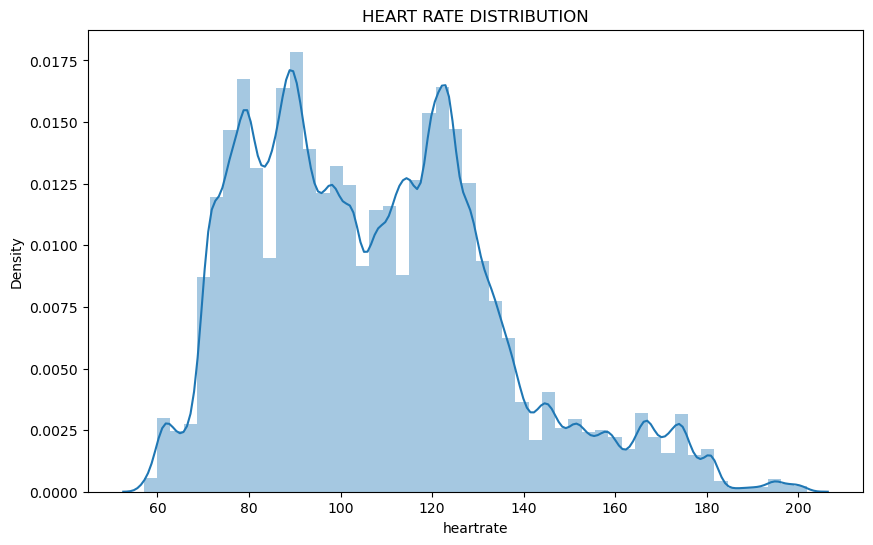

In [16]:
# Visualize the distribution of heartrate

fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(data['heartrate'])
plt.title("HEART RATE DISTRIBUTION")
plt.show()

The distribution plot shows a positive skew. Positive skew is when the right tail of a distribution is longer; the mass of the distribution is concentrated on the left of the figure. The distribution is said to be right-skewed, right-tailed, or skewed to the right, despite the fact that the curve itself appears to be skewed or leaning to the left; right instead refers to the right tail being drawn out and, often, this mean being skewed to the right of a typical center of the data. A right-skewed distribution usually appears as a left-leaning curve. The mean of this distribution would be located on the right side of the graph and would be greater than the median or mode. This shape indicates that there are a number of data points, perhaps outliers, that are greater than the mode. ie: Mean > Median > Mode. A greater percentage of the of the heartrate seems to be clustered around 70 and 140. To better understand the skewness of the heartrate distribution, I plotted a boxplot.

The boxplot shows that most of the recorded heartrate is clustered around the mean and ranges from 86 - 124. It also clearly shows what would be considered outlier starting at 180 - 202. Outliers are observations that lies an abnormal distance from other values in a sample. The could affect the the mean of a sample and hence some analysis or test that assume normal distribution. For the purpose of this analysis, no outlier would be removed.

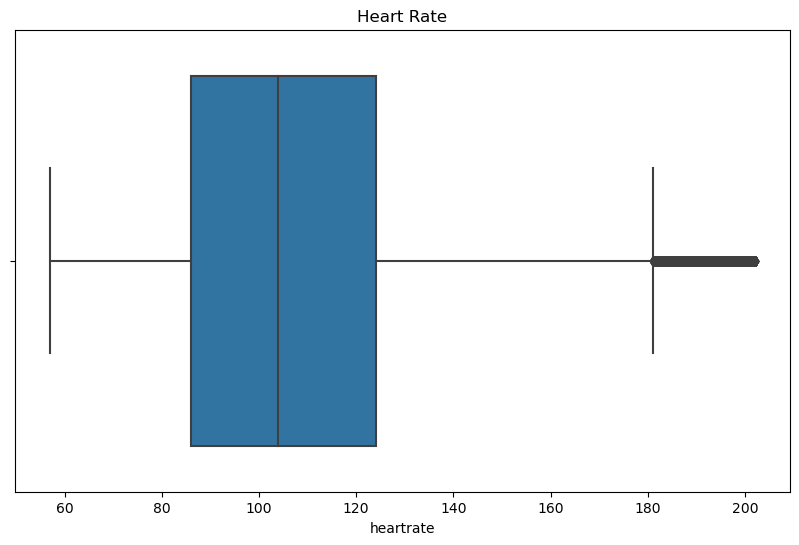

In [17]:
# Boxplot of Heartrate

fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data['heartrate'])
plt.title("Heart Rate")
plt.show()

When rigorous or tasking activities are performed, heartrate is expected to be higher. Here, I plot a barchart to visualze the heartrate for each activity performed

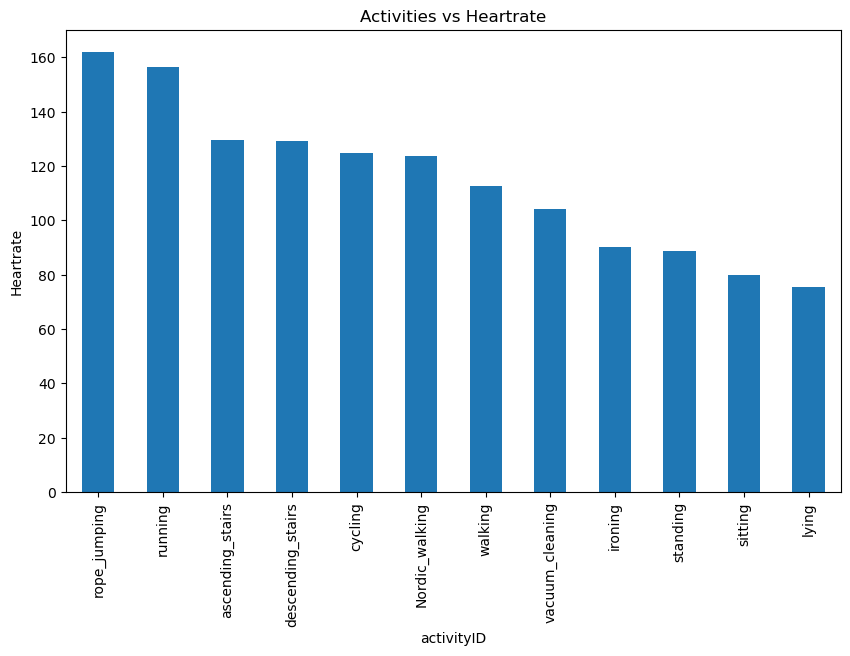

In [18]:
# Barchart of activities and Heartrate

activity_distribution = data['heartrate'].groupby(by=data['activityID']).mean().sort_values(ascending=False)
activity_distribution.index = activity_distribution.index.map(activities)
fig, ax = plt.subplots(figsize=(10,6))
activity_distribution.plot(kind = 'bar')
plt.title('Activities vs Heartrate')
plt.ylabel('Heartrate')
plt.plot()
plt.show()

#sns.barplot(x='activityID', y='heartrate', data=activity_distribution)

The bar graph demonstrates that the activities, rope jumping and running are the most taxing with heartrates well over 150bpm, while ascending stairs and cycling could be considered moderate activities. Sitting and lying are the least taxing with heartrating ranging between 70 - 80 bpm.

### 4.2. SUBJECT ANALYSIS

In this subsection, I analysed the users / subjects with the timestamp of the activities they performed. I first of all define a plot function to enable me create plots more eaaily.

In [19]:
# Function to create plots

def pd_fast_plot(pd,column_a,column_b,title, figsize=(10,6)):
    plt.rcParams.update({'font.size': 16})
    size = range(len(pd))
    f, ax = plt.subplots(figsize=figsize) 
    plt.bar(size, pd[column_a], color=plt.cm.Paired(size))
    a = ax.set_xticklabels(pd[column_b], rotation = (90))
    b = ax.legend(fontsize = 20)
    c = ax.set_xticks(np.arange(len(pd)))
    d = ax.set_title(title)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


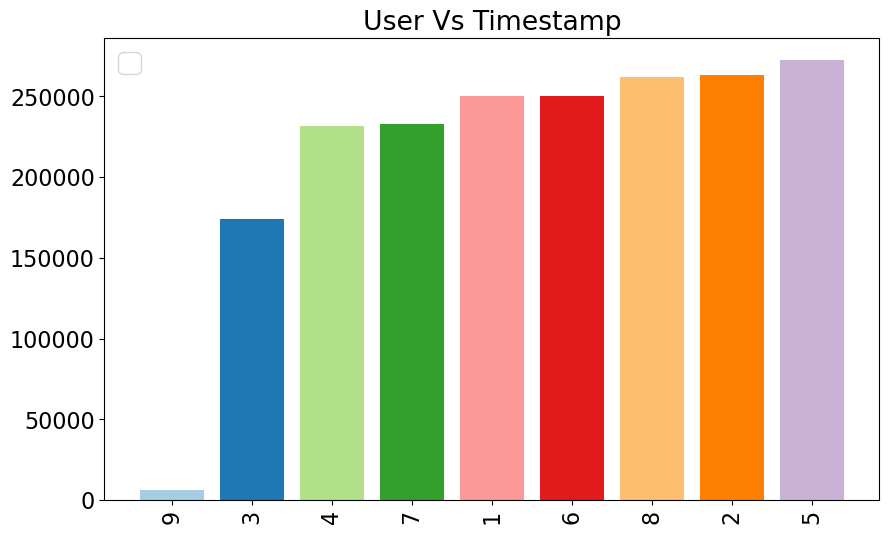

In [20]:
#Get required data and plot with defined function

sample = data.groupby(['subject_id']).count().reset_index()
sample_to_subject = pd.DataFrame()
sample_to_subject['id'] = sample['subject_id']
sample_to_subject['sample'] = sample['timestamp']
sample_to_subject = sample_to_subject.sort_values(by=['sample'])
pd_fast_plot(sample_to_subject,'sample','id','User Vs Timestamp')

The bar graph above shows that subject / user 9 had the least rcorded performance. This could have been as a result of malfunction from the machine. The data from this subject should be considered for removal as it might affect result from analysis. On the other hand, subject 5 has the most recorded activity. 

Below, I visualized the activities performed by the varying timestamp to understand what activities were performed most by the subjects. It is clear and quite normal to see that walking had the highest timestamp as most of human activities involve walking. Rope jumping had the lowest timestamp and is hence, the least performed activity by the subjects.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


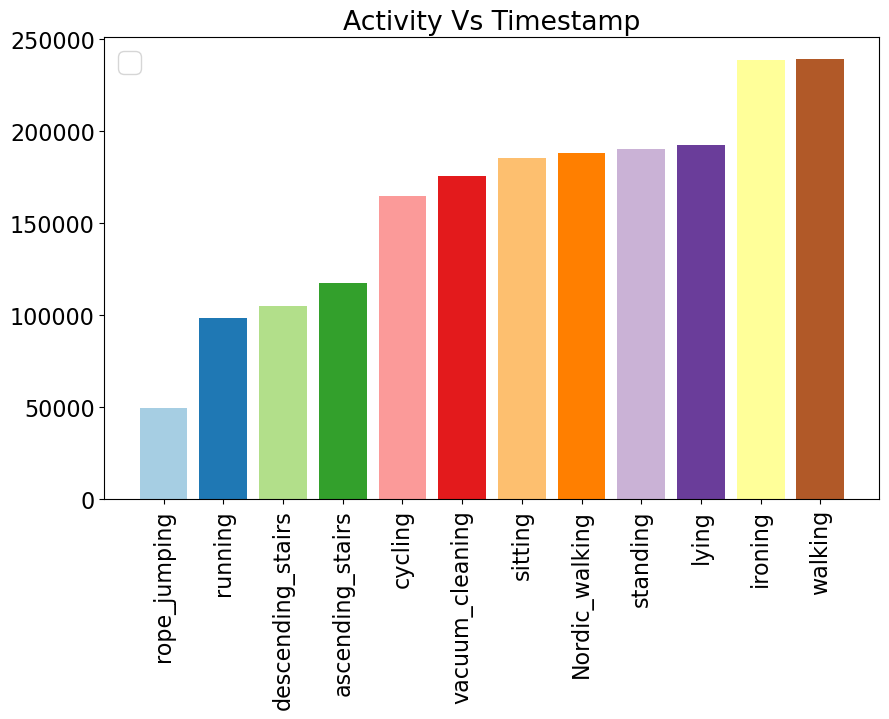

In [21]:
#Get required data and plot with defined function

sample = data.groupby(['activityID']).count().reset_index()
sample_to_subject = pd.DataFrame()
sample_to_subject['activity'] = [activities[x] for x in sample['activityID']]
sample_to_subject['sample'] = sample['timestamp']
sample_to_subject = sample_to_subject.sort_values(by=['sample'])
pd_fast_plot(sample_to_subject,'sample','activity','Activity Vs Timestamp')

### 4.3. TEMPERATURE ANALYSIS

In this sub section, I analysed the average temperature readings gotten from the hand, chest and ankle of the various subjects. Overall, the higest temperature recorded was from the chest, while the hand was the least. 
We can see a drop in temperature across all three readings as we get to subject 9. This can be explained from the previous plot titled User Vs Timestamp that showed subject 9 had the least amount of recorded activity. It is expected that this subject would have the least recorded temperature and hence derail from the usual trend as seen in the line plot below. Subject 5 has the highest recorded temperature from the hand and chest, while subject 6 has the highest recorded temperature from the ankle.

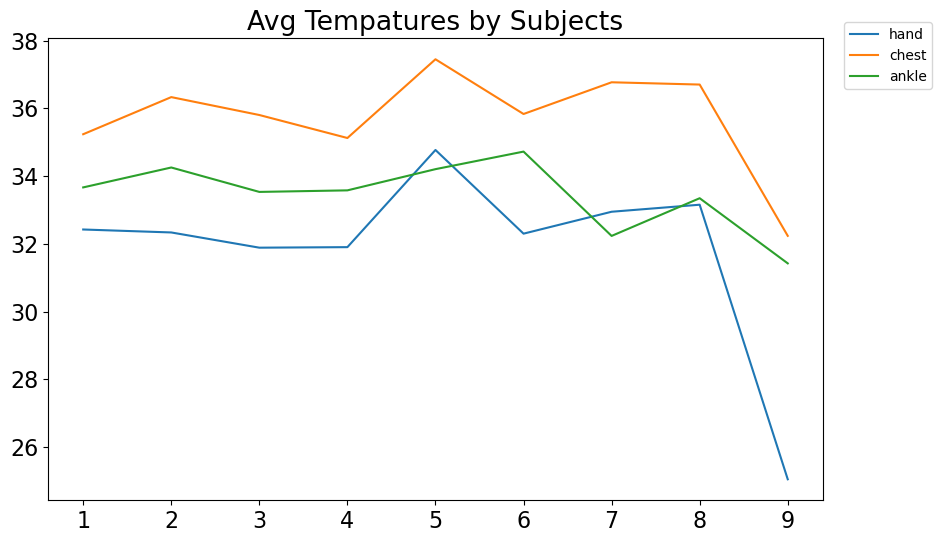

In [22]:
#Get required data and plot

result_id = data.groupby(['subject_id']).mean().reset_index()
sample_temp = pd.DataFrame()
sample_temp['hand'] = result_id['handTemperature']
sample_temp['chest'] = result_id['chestTemperature']
sample_temp['ankle'] = result_id['ankleTemperature']

ax = sample_temp.plot(kind='line', figsize=(10,6), title='Avg Tempatures by Subjects')
a = ax.set_xticklabels(result_id['subject_id'])
b = ax.legend(fontsize = 10, bbox_to_anchor=(1.15, 1.05))
c = ax.set_xticks(np.arange(len(sample_temp)))

Here, I analysed the recorded temperature and the activities performed. There is a dip across all three recorded temperature trend in running and rope jumping. This is no suprise as rope jumping and running had the least Timestamp as shown in the plot titled Activity vs Timestamp, indicating that there are few data points recorded for these activities. It could be as a result of the machines malfunctioning while the subjects performed the activities or that it wasn't an activity that was perfrmed often by the subjects.

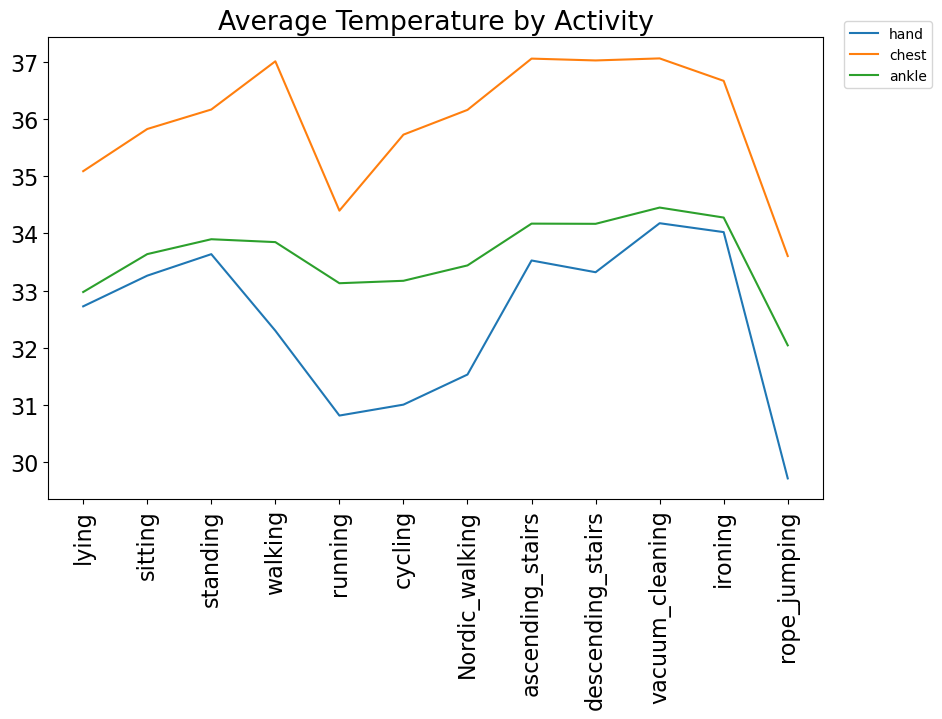

In [23]:
#Get required data and plot

result_act = data.groupby(['activityID']).mean().reset_index()
sample_temperature = pd.DataFrame()
sample_temperature['activity'] = [activities[x] for x in result_act['activityID']]
sample_temperature['hand'] = result_act['handTemperature']
sample_temperature['chest'] = result_act['chestTemperature']
sample_temperature['ankle'] = result_act['ankleTemperature']

ax = sample_temperature.plot(kind='line', figsize=(10,6), title='Average Temperature by Activity')
a = ax.set_xticklabels(sample_temperature['activity'], rotation =90)
b = ax.legend(fontsize = 10, bbox_to_anchor=(1.15, 1.05))
c = ax.set_xticks(np.arange(len(sample_temperature)))

### 4.4. SENSOR ANALYSIS

In this subsection, I analysed the acceleration detected by the sensors with the subjects. The subjects seem to follow the same trend across the hand, chest and ankle acceleration recorded by the sensors. However, there is a huge dip in the trend in the hand acceleration recorded by sensor: 'handAcc16_2' as we get to subject 8. Could this be as as a result of malfunction by the sensor?

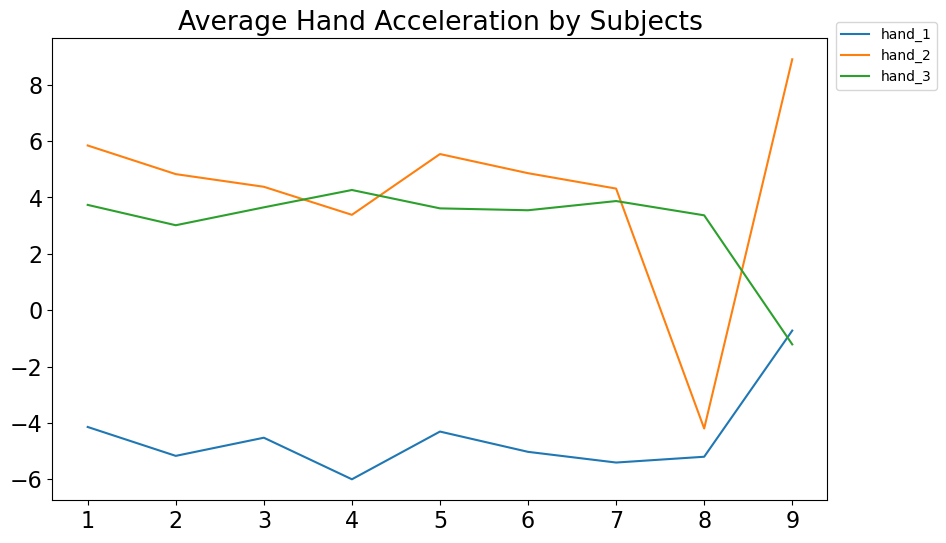

In [24]:
#Get required data and plot

samp = pd.DataFrame()
samp['hand_1'] = result_id['handAcc16_1']
samp['hand_2'] = result_id['handAcc16_2']
samp['hand_3'] = result_id['handAcc16_3']
ax = samp.plot(kind='line', figsize=(10,6), title='Average Hand Acceleration by Subjects')
a = ax.set_xticklabels(result_id['subject_id'])
b = ax.legend(fontsize = 10, loc=1, bbox_to_anchor=(1.15, 1.05))
c = ax.set_xticks(np.arange(len(samp)))

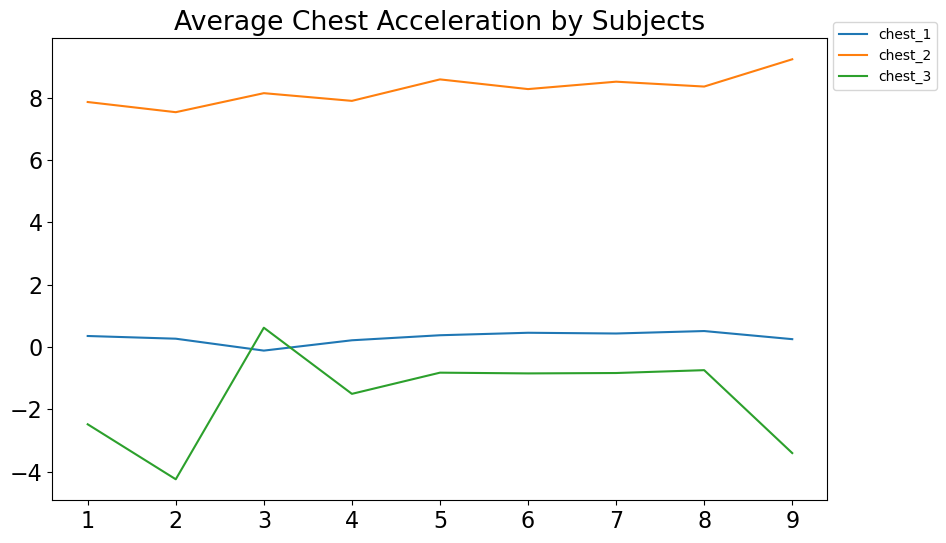

In [25]:
#Get required data and plot

samp = pd.DataFrame()
samp['chest_1'] = result_id['chestAcc16_1']
samp['chest_2'] = result_id['chestAcc16_2']
samp['chest_3'] = result_id['chestAcc16_3']
ax = samp.plot(kind='line', figsize=(10,6), title='Average Chest Acceleration by Subjects')
a = ax.set_xticklabels(result_id['subject_id'])
b = ax.legend(fontsize = 10, loc=1, bbox_to_anchor=(1.15, 1.05))
c = ax.set_xticks(np.arange(len(samp)))

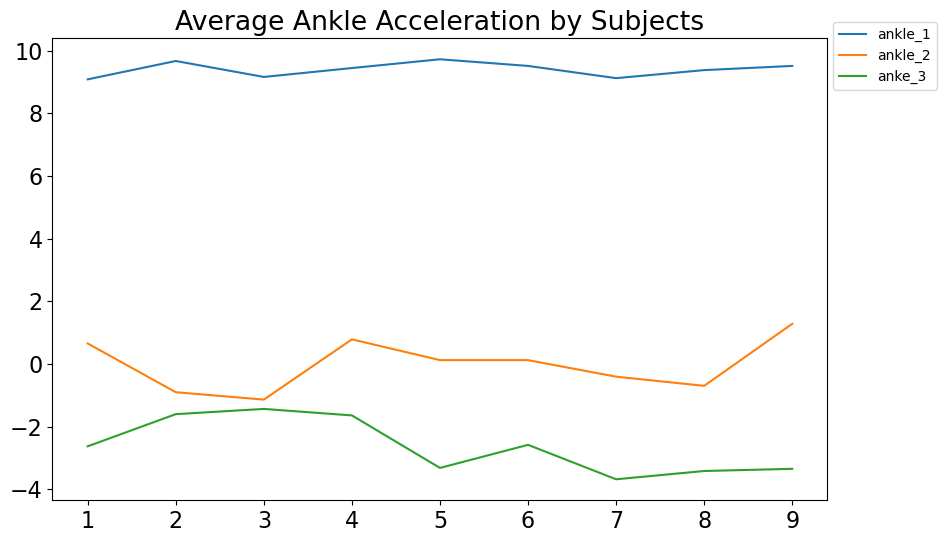

In [26]:
#Get required data and plot

samp = pd.DataFrame()
samp['ankle_1'] = result_id['ankleAcc16_1']
samp['ankle_2'] = result_id['ankleAcc16_2']
samp['anke_3'] = result_id['ankleAcc16_3']
ax = samp.plot(kind='line', figsize=(10,6), title='Average Ankle Acceleration by Subjects')
a = ax.set_xticklabels(result_id['subject_id'])
b = ax.legend(fontsize = 10, loc=1, bbox_to_anchor=(1.15, 1.05))
c = ax.set_xticks(np.arange(len(samp)))


### 4.5. DATA SPLITTING

Befor performing further analysis, I split the dataset in the ratio 70:30. 70% of the the data would be used for Training and hypothesis testing while the remaining 30% would be used for Testing. This is done to avaoid data leakage that could result in developing a biased model that does not perform well with unseen data.

In [27]:
#Split data

train_data = data.iloc[:int(data.shape[0]*0.7)]
test_data = data.iloc[int(data.shape[0]*0.7):]

### 4.6. CORRELATION

Correlation is any statistical relationship between two random variables. Correlations are useful because they can indicate a predictive relationship that can be exploited. Here, I use pandas corrlation function (method = pearson) to compute pairwise correlation of columns. The result is the table below which is not particularly intuitive at first glance. I create a heat map using seaborns heatmap plot to further illustrate whether there are any relationships between our data and to examine it for anomalies.

In [28]:
# Compute correlation

df_corr = train_data.corr()
df_corr = df_corr.drop(['activityID'], axis = 1)
df_corr

,timestamp,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,handGyro3,handMagne1,handMagne2,handMagne3,chestTemperature,chestAcc16_1,chestAcc16_2,chestAcc16_3,chestAcc6_1,chestAcc6_2,chestAcc6_3,chestGyro1,chestGyro2,chestGyro3,chestMagne1,chestMagne2,chestMagne3,ankleTemperature,ankleAcc16_1,ankleAcc16_2,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,subject_id
timestamp,1.000000,0.796079,-0.486137,-0.377472,0.109490,-0.218422,-0.386643,0.113520,-0.229087,0.032345,0.030115,0.006709,0.336052,-0.174538,0.105203,-0.030380,-0.038901,0.145357,-0.507712,-0.035260,0.146760,-0.509921,0.005687,0.017458,-0.009098,-0.201055,-0.347600,0.531180,-0.114561,0.347728,0.290247,-0.012632,0.357588,0.312453,-0.017862,-0.010433,-0.053024,0.001998,-0.285789,-0.318412,-0.040645,-0.136075
activityID,0.209103,0.298591,0.155399,-0.175530,0.093864,-0.141014,-0.174880,0.094950,-0.141764,0.030296,0.029155,0.003586,0.045201,-0.268908,0.015316,0.164152,-0.210701,0.109682,-0.448345,-0.208493,0.108103,-0.448959,0.001684,-0.018668,-0.000013,-0.248494,-0.297792,0.275953,0.208630,0.151769,0.147106,0.083457,0.157824,0.156203,0.092577,-0.001602,0.012536,0.001387,-0.185861,-0.041697,0.237223,-0.001908
heartrate,0.796079,1.000000,-0.352506,-0.365052,0.122778,-0.247507,-0.372485,0.127449,-0.256475,0.031601,0.039855,0.003076,0.350727,-0.197813,0.125307,-0.064055,-0.020550,0.158380,-0.437037,-0.018825,0.160584,-0.439813,0.007133,0.015210,-0.020090,-0.200332,-0.428134,0.480507,-0.081759,0.307089,0.290127,-0.038142,0.315028,0.312213,-0.045689,-0.006633,-0.033239,0.005497,-0.328235,-0.352842,-0.068748,-0.251967
handTemperature,-0.486137,-0.352506,1.000000,0.096135,0.021213,0.065248,0.109869,0.020106,0.082396,-0.028880,-0.000576,0.001893,-0.145214,-0.068328,-0.026703,0.734307,-0.010713,0.058846,0.107579,0.003059,0.056180,0.116501,0.000181,-0.003371,-0.006466,0.004140,-0.010136,-0.174127,0.624917,-0.054144,-0.076927,-0.060543,-0.053083,-0.083669,-0.060225,0.007536,0.038672,0.001615,0.102368,0.140481,0.145841,0.389066
handAcc16_1,-0.377472,-0.365052,0.096135,1.000000,-0.077490,0.212970,0.986960,-0.089135,0.214057,0.046678,-0.037210,0.032838,-0.518759,0.093425,-0.242497,-0.187240,0.043152,-0.430926,0.497796,0.039473,-0.433302,0.497404,-0.059644,-0.071407,0.071948,0.263982,0.349883,-0.388107,-0.220988,-0.345562,-0.198295,-0.010994,-0.366401,-0.217576,-0.012830,0.031106,-0.007046,0.118564,0.108889,0.276390,-0.094157,0.002197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ankleGyro3,0.001998,0.005497,0.001615,0.118564,-0.031735,0.035388,0.103156,-0.012398,0.042384,0.124396,-0.017331,-0.196840,0.081460,0.059810,0.021489,0.004769,-0.048028,-0.150395,0.093441,-0.046750,-0.130985,0.086330,-0.065658,-0.113531,0.255000,0.000782,-0.005391,0.001521,0.002274,-0.048751,0.151548,-0.056544,-0.088136,0.089343,-0.048424,0.283497,-0.033444,1.000000,-0.008388,0.011639,-0.020888,0.001606
ankleMagne1,-0.285789,-0.328235,0.102368,0.108889,-0.061735,0.061414,0.110702,-0.064572,0.063227,0.016898,-0.017855,-0.080413,-0.027476,0.295467,0.133976,0.038700,0.009636,-0.111577,0.234638,0.008347,-0.111666,0.234829,0.008786,-0.052408,0.040636,0.163562,0.572144,-0.153672,0.036632,-0.212621,-0.147161,-0.002082,-0.214474,-0.156621,-0.002586,-0.018788,0.013130,-0.008388,1.000000,0.047348,-0.047180,0.249602
ankleMagne2,-0.318412,-0.352842,0.140481,0.276390,-0.053699,0.124558,0.281894,-0.056051,0.129773,-0.046725,-0.033634,0.120233,-0.381928,0.105439,-0.294922,0.001091,0.035901,-0.198346,0.325808,0.033975,-0.202641,0.327870,-0.003803,0.058369,-0.009743,0.303769,0.205729,-0.622619,-0.001743,-0.136207,-0.081053,-0.067471,-0.140666,-0.085780,-0.076008,0.048790,-0.051950,0.011639,0.047348,1.000000,0.004618,0.105299
ankleMagne3,-0.040645,-0.068748,0.145841,-0.09

The heatmap plot shows some high negative relationship between ChestMagne3 and ChestAcc16_3 / ChestAcc6_3. ie: As the reading in one sensor increases, the other decreases and vice versa. There is also high positive relationship seen between the chestTemperature and the ankleTemperature. ie: As the chest temperature increases the ankle temperature increases as well. There are many other notable relationships that can be seen on proper examination.

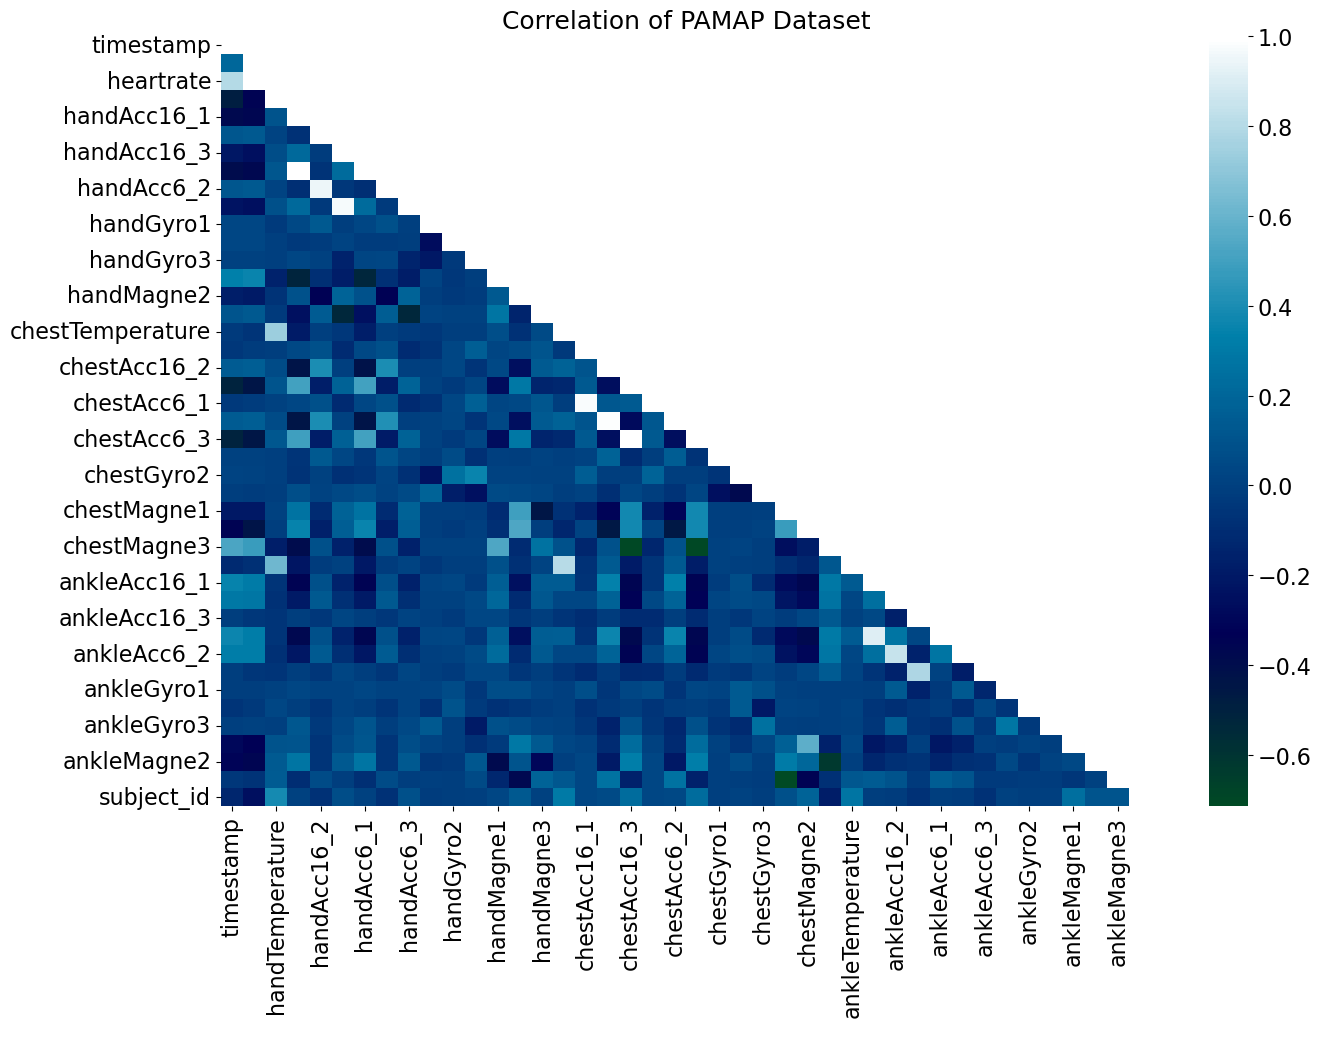

In [29]:
# Heatmap Plot

f, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(df_corr, dtype=bool))
sns.heatmap(df_corr, mask=mask, vmax=1,center=0, cmap = 'ocean', annot = False)
plt.title('Correlation of PAMAP Dataset', fontsize=18)
plt.xlabel(' ',)
plt.show()

Here, I used pandas corrwith function to compute a pairwise relationship between the heartrate and other features in the dataset. The chestMagne3 with correlation of 0.480 indicates a positive relationship with the heartrate while the chestAcc6_3 with correlation of -0.439 indicates a negative relationship with the heartrate.

In [30]:
# Feature correlation with heartrate

train_data.corrwith(train_data['heartrate']).sort_values(ascending = False)

heartrate       1.000000
timestamp       0.796079
chestMagne3     0.480507
handMagne1      0.350727
ankleAcc6_1     0.315028
                  ...   
handAcc16_1    -0.365052
handAcc6_1     -0.372485
chestMagne2    -0.428134
chestAcc16_3   -0.437037
chestAcc6_3    -0.439813
Length: 43, dtype: float64

### 4.7. PREPROCESSING

* Running and rope jumping appear to be the most difficult or rigorous activities, as seen by the bar chart created earlier. 
* Ascending stairs, descending stairs, cycling, nordic walking, walking and vaccuum cleaning can be classed as moderate exercises. 
* Lying, sitting, standing, ironing are classed as light activities.

Therefore, based on how these grouped activities and their heart rate data corresponds with the heart rates of the other activities, the activities will serve as the basis for my hypothesis test. This will be accomplished by calculating the average heart rate for a grouped activity, comparing it to the average heart rate for another activity, and then performing the analysis.

### 4.7.1. GROUP ACTIVITIES TO DATAFRAME
Before performing any hypothesis test, I grouped the activities into distinct dataframes:
- rigorous_activities
- moderate_activities
- light_activities

#### Rigorous Activity
* Running
* Rope jumping

In [31]:
running_df = train_data.query("activityID == 5")
running_df.head()

rope_jumping_df =train_data.query("activityID == 24")
rope_jumping_df.head()

rigorous_activities = pd.concat([running_df, rope_jumping_df])
rigorous_activities.shape

(89057, 43)

#### Moderate Activity
* Ascending stairs
* Descending stairs
* Cycling 
* Nordic walking
* Walking
* Vaccuum cleaning

In [32]:
asc_df = train_data.query("activityID == 12")
dsc_df =train_data.query("activityID == 13")
cyc_df = train_data.query("activityID == 6")
nor_df =train_data.query("activityID == 7")
wal_df = train_data.query("activityID == 4")

moderate_activities = pd.concat([asc_df, dsc_df, cyc_df, nor_df, wal_df])
moderate_activities.shape

(533493, 43)

#### Light Activity
* Lying
* Sitting 
* Standing 
* Ironing

In [33]:
ly_df = train_data.query("activityID == 1")
sit_df =train_data.query("activityID == 2")
stand_df = train_data.query("activityID == 3")
iron_df =train_data.query("activityID == 17")

light_activities = pd.concat([ly_df, sit_df, stand_df, iron_df])
light_activities.shape

(607951, 43)

### 4.7.2. AVERAGE HEARTRATE FOR THE DIFFERENT ACTIVITIES

Here, I calculated the average heartrate for the different grouped activities. This will be used to develop and perform hypothesis testing.

#### AVERAGE HEARTRATE FOR RIGOROUS ACTIVITIES

In [34]:
rig_act_mean = rigorous_activities['heartrate'].mean()
rig_act_mean

157.35982107218842

#### AVERAGE HEARTRATE FOR MODERATE ACTIVITIES

In [35]:
mod_act_mean = moderate_activities['heartrate'].mean()
mod_act_mean

124.27817444022492

#### AVERAGE HEARTRATE FOR LIGHT ACTIVITIES

In [36]:
lig_act_mean = light_activities['heartrate'].mean()
lig_act_mean

86.06817950817475

### 4.7.3. FILTER ACTIVITIES FROM TEST DATA

Here, I grouped the activities in the test data into rigorous activities, moderate activities and light activities as I did with the train data

#### RIGOROUS ACTIVITIES FROM TEST DATA

In [37]:
test_data.shape

(582862, 43)

In [38]:
running_df2 = test_data.query("activityID == 5")
rope_jumping_df2 =test_data.query("activityID == 24")

rigorous_activities2 = pd.concat([running_df2, rope_jumping_df2])
rigorous_activities2.shape

(58502, 43)

In [39]:
rigorous_activities2['heartrate'].mean()

159.97166763529452

#### MODERATE ACTIVITIES FROM TEST DATA

In [40]:
asc_df2 = test_data.query("activityID == 12")
dsc_df2 =test_data.query("activityID == 13")
cyc_df2 = test_data.query("activityID == 6")
nor_df2 =test_data.query("activityID == 7")
wal_df2 = test_data.query("activityID == 4")

moderate_activities2 = pd.concat([asc_df2, dsc_df2, cyc_df2, nor_df2, wal_df2])
moderate_activities2.shape

(280135, 43)

In [41]:
moderate_activities2['heartrate'].mean()

118.56156358678717

#### LIGHT ACTIVITIES FROM TEST DATA

In [42]:
ly_df2 = test_data.query("activityID == 1")
sit_df2 =test_data.query("activityID == 2")
stand_df2 = test_data.query("activityID == 3")
iron_df2 =test_data.query("activityID == 17")

light_activities2 = pd.concat([ly_df2, sit_df2, stand_df2, iron_df2])
light_activities2.shape

(198381, 43)

In [43]:
light_activities2['heartrate'].mean()

77.38483440114392

## 5. HYPOTHESIS TESTING

A statistical hypothesis test is a method of statistical inference used to decide whether the data at hand sufficiently support a particular hypothesis. Hypothesis testing allows us to make probabilistic statements about population parameters.

The set of hypotheses that will be tested relates to what was determined during exploratory data analysis that the heartrate data might potentially allow for the classification of activities. Two hypotheses about the mean of heartrate data for each activity classification will be examined to see if this evaluation is accurate.

---
### 5.1. HYPOTHESIS 1
---
### 5.1.1 HYPOTHESIS STATEMENT

**If** there is a relationship between *activities performed* and *heartrate*, **then**, moderate activities will result in a higher heartrate than lighter activities

- Independent Variable : *activityID*
- Dependent Variable : *heartrate*

> Null hypothesis ($H_0$) : The average heart rate for moderate activities is the same as the average for light activities.

> Alternative hypothesis ($H_1$) : The average heart rate for moderate tasks differs significantly from the average for light activities.

$H_0$ : x = 124.27

$H_1$ : x > 124.27

Where x is the mean heartrate of **moderate activities** (mod_act_mean).

*alpha level = 0.05*

If p-value < 0.05 : I reject null hypothesis
If p-value > 0.05 : I accept null hypothesis

### 5.1.2. CALCULATE Z-SCORE

Z-score is a statistical measurement that describes a value's relationship to the mean of a group of values. Z-score is measured in terms of standard deviations from the mean. If a Z-score is 0, it indicates that the data point's score is identical to the mean score. A Z-score of 1.0 would indicate a value that is one standard deviation from the mean. Z-scores may be positive or negative, with a positive value indicating the score is above the mean and a negative score indicating it is below the mean.

   **$z = (x - μ) / σ$**

Z-score is used here instead of t-test because our sample population is well above 30.
I first calculated the statistics necessary to get Z-score and then calculated the Z-score and p-value using the test data

In [44]:
# Get statistics
# Mean
test_means = moderate_activities2['heartrate'].mean()
print('mean:', test_means)
print()

# Standard deviation
test_std = moderate_activities2['heartrate'].std()
print('std:', test_std)
print()

# Count
test_count = moderate_activities2['heartrate'].count()
print('count:', test_count)

mean: 118.56156358678717

std: 16.677299510588295

count: 280135


In [45]:
#Calculate the z-score
zscore = (test_means - mod_act_mean)/(test_std/np.sqrt(test_count))
print('z-score:', zscore)

# Get p_value
p_value_from_normal=1-stats.norm.cdf(zscore)
print(p_value_from_normal)
alpha = 5e-2

print('The Average is: ',test_means)
print()
if p_value_from_normal <= alpha:
    print("The p_value is:", p_value_from_normal, "Null hypothesis can be rejected")
else:
    print("The p_value is:", p_value_from_normal, "Null hypothesis cannot be rejected")  

z-score: -181.42477265898955
1.0
The Average is:  118.56156358678717

The p_value is: 1.0 Null hypothesis cannot be rejected


The **p-value** for the hypothesis test is $1.0$  which is greater than the **alpha value** used for this test. This means the **Null hypothesis ($H_0$)** : The average heart rate for moderate activities is the same as the average for light activities must be **accepted** and the Alterantive hypothesis ($H_1$) : The average heart rate for moderate tasks differs significantly from the average for light activities should be rejected. 
Hence, according to the result from the test, there is no significant differnce in the average heartrate for moderate activities and light activities.

## 5.2. HYPOTHESIS 2
---

### 5.2.1. HYPOTHESIS STATEMENT

**If** there is a relationship between *activities performed* and *heartrate*, **then**, rigorous activities will result in a higher heartrate than moderate activities

- Independent Variable : *activityID*
- Dependent Variable : *heartrate*

> Null hypothesis ($H_0$) : The average heart rate for rigorous tasks is the same as the average for moderate (other) activities.

> Alternative hypothesis ($H_1$) : The average heart rate for rigorous tasks differs significantly from the average for moderate (other) activities.

$H_0$ : x = 157.35

$H_1$ : x > 157.35

Where x is the mean heartrate of **rigorous activities**.

*alpha level = 0.05*

If p-value < 0.05 : I reject null hypothesis
If p-value > 0.05 : I accept null hypothesis

### 5.2.2. CALCULATE Z-SCORE

Z-score is used here instead of t-test because our sample population is well above 30.
I first calculated the statistics necessary to get Z-score and then calculated the Z-score and p-value using the test data

In [46]:
# Get statistics
# Mean
test_means = rigorous_activities2['heartrate'].mean()
print('mean:', test_means)
print()

# Standard deviation
test_std = rigorous_activities2['heartrate'].std()
print('std:', test_std)
print()

# Count
test_count = rigorous_activities2['heartrate'].count()
print('count:', test_count)

mean: 159.97166763529452

std: 26.330938461932032

count: 58502


In [47]:
#Calculate the z-score
zscore = (test_means - rig_act_mean)/(test_std/np.sqrt(test_count))
print('z-score:', zscore)

# Get p_value
p_value_from_normal = 1 - stats.norm.cdf(zscore)
print(p_value_from_normal)
alpha = 5e-2

print('The Average is: ',test_means)
print()
if p_value_from_normal <= alpha:
    print("The p_value is:", p_value_from_normal, "Null hypothesis can be rejected")
else:
    print("The p_value is:", p_value_from_normal, "Null hypothesis cannot be rejected")  

z-score: 23.992012483740865
0.0
The Average is:  159.97166763529452

The p_value is: 0.0 Null hypothesis can be rejected


The resulting **p-value** from this hypothesis test is $0.0$  which is less than the **alpha value** $0.05$ used for this test. This means the Null hypothesis ($H_0$) : The average heart rate for rigorous tasks is the same as the average for moderate (other) activities must rejected and the **Alterantive hypothesis ($H_1$)** : The average heart rate for rigorous tasks differs significantly from the average for moderate (other) activities must be **accepted**. 
Hence, according to the result from the test, there is indeed a significant difference in the average heartrate for rigorous activities and other activities. The average heartrate for rigorous activities is expected to be higher than other activities.

## 6. MODELLING

In order to improve the accuracy of our model, some variables must be eliminated. The variables that must be eliminated are subject id and timestamp since these are numerical values that the algorithm  would employ in its calculations but whose values have no significance. They could lead to errors and inaccurate forecasts.

#### 6.1 DROP UNNECESSARY FEATURES

In [48]:
# Drop timestamp and subject_id features

df_train = train_data.drop(['timestamp', 'subject_id'], axis=1)
df_test = test_data.drop(['timestamp', 'subject_id'], axis=1)
df_train.head(3)

,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,handGyro3,handMagne1,handMagne2,handMagne3,chestTemperature,chestAcc16_1,chestAcc16_2,chestAcc16_3,chestAcc6_1,chestAcc6_2,chestAcc6_3,chestGyro1,chestGyro2,chestGyro3,chestMagne1,chestMagne2,chestMagne3,ankleTemperature,ankleAcc16_1,ankleAcc16_2,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3
0,1,100.0,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,-0.004750,0.037579,-0.011145,8.93200,-67.9326,-19.9755,32.1875,0.124482,9.65003,-1.65181,0.143941,9.71019,-1.47347,0.036668,0.016559,-0.052791,0.567566,-50.7269,44.2728,30.75,9.73855,-1.84761,0.095156,9.63162,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696
1,1,100.0,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,-0.171710,0.025479,-0.009538,9.58300,-67.9584,-20.9091,32.1875,0.200711,9.64980,-1.65043,0.129092,9.74041,-1.47329,0.019343,-0.024304,-0.059843,0.904990,-50.5080,43.5427,30.75,9.69762,-1.88438,-0.020804,9.58649,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656
2,1,100.0,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,-0.238241,0.011214,0.000831,9.05516,-67.4017,-19.5083,32.1875,0.270277,9.72331,-1.88174,0.144685,9.77048,-1.41285,-0.001428,0.038466,-0.046464,0.455480,-50.7209,44.0259,30.75,9.69633,-1.92203,-0.059173,9.60196,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119


#### 6.2. SCALING

Since our data contains many outliers, scaling using the mean and variance of the data is likely to not work very well. In this case, **RobustScaler** is uded as a drop-in replacement instead for standard scaler or minmax scaler. It uses more robust estimates for the center and range of your data.

In [49]:
#apply scaling to all columns except subject and activity

scaler = RobustScaler()
df_scaled = df_train
df_test_scaled = df_test

df_scaled.iloc[:,1:41] = scaler.fit_transform(df_scaled.iloc[:,1:41])
df_test_scaled.iloc[:,1:41] = scaler.fit_transform(df_test_scaled.iloc[:,1:41])

df_scaled.head()

,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,handGyro3,handMagne1,handMagne2,handMagne3,chestTemperature,chestAcc16_1,chestAcc16_2,chestAcc16_3,chestAcc6_1,chestAcc6_2,chestAcc6_3,chestGyro1,chestGyro2,chestGyro3,chestMagne1,chestMagne2,chestMagne3,ankleTemperature,ankleAcc16_1,ankleAcc16_2,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3
0,1,-0.108108,-1.382353,0.920228,0.843040,0.375873,0.911392,0.901614,0.362251,0.000237,0.063611,-0.007646,-0.371650,-1.662069,0.160101,-2.275862,-0.178354,0.130539,0.013089,-0.084468,0.160248,-0.021732,0.163231,0.059396,-0.177636,-0.107577,-1.072404,1.336159,-3.235294,0.098569,-0.384942,0.793404,0.015551,-0.376044,0.676344,0.000133,-0.112169,0.010679,-1.072035,-1.209271,-2.613136
1,1,-0.108108,-1.382353,0.929559,0.715242,0.407125,0.914652,0.815121,0.365395,-0.233198,0.038458,-0.005374,-0.352485,-1.662963,0.127783,-2.275862,-0.132073,0.130480,0.013369,-0.093622,0.167911,-0.021696,0.082931,-0.081632,-0.211923,-0.091124,-1.059768,1.312348,-3.235294,0.072171,-0.394367,0.749754,-0.013473,-0.372248,0.670741,0.062503,0.033810,0.019479,-1.063307,-1.191591,-2.613003
2,1,-0.108108,-1.382353,0.929430,0.603421,0.422787,0.914158,0.712666,0.365605,-0.326219,0.008805,0.009285,-0.368024,-1.643683,0.176274,-2.275862,-0.089838,0.149419,-0.033632,-0.084009,0.175535,-0.009581,-0.013334,0.135002,-0.146870,-0.113043,-1.072057,1.328107,-3.235294,0.071339,-0.404018,0.735310,-0.003524,-0.368412,0.710409,-0.132772,-0.238024,-0.003043,-1.041099,-1.174184,-2.621156
3,1,-0.108108,-1.382353,0.920557,0.603684,0.437878,0.908341,0.626305,0.383636,-0.262842,0.025102,0.027019,-0.342359,-1.644964,0.139861,-2.275862,-0.110201,0.149717,-0.002283,-0.065687,0.171706,-0.018714,0.073357,-0.165299,-0.285365,-0.119440,-1.039356,1.316076,-3.235294,0.050294,-0.384822,0.793114,-0.013312,-0.379832,0.693473,-0.122783,-0.066986,0.062795,-1.058187,-1.217047,-2.596925
4,1,-0.108108,-1.382353,0.930666,0.627908,0.476320,0.906571,0.623139,0.398518,-0.090938,-0.052603,0.014588,-0.365048,-1.636092,0.156286,-2.275862,-0.040086,0.149692,0.006010,-0.066202,0.156427,-0.033894,-0.005444,-0.043833,-0.112108,-0.112709,-1.071486,1.292132,-3.235294,0.122581,-0.394736,0.793637,0.025294,-0.372230,0.687643,-0.005270,-0.219973,-0.006033,-1.035588,-1.217687,-2.597084


#### 6.3. DEPENDENT AND NON-DEPENDENT FEATURES

The purpose of this analysis is to build a model that can predict the various activities performed by the subjects using data provided from the sensor readings and other existing features in the dataset. The feature that is been predicted: **activityID** is therefore seperated from other features in both the train and test data

In [50]:
# Train dataset

X_train = df_scaled.drop('activityID', axis=1).values
y_train = df_scaled['activityID'].values

# Test Dataset

X_test = df_test_scaled.drop('activityID', axis=1).values
y_test = df_test_scaled['activityID'].values
y_test

array([ 4,  4,  4, ..., 24, 24, 24], dtype=int64)

#### 6.4. DIMENSIONALITY REDUCTION USING PCA

Dimensionality reduction, or dimension reduction, is the transformation of data from a high-dimensional space into a low-dimensional space so that the low-dimensional representation retains some meaningful properties of the original data, ideally close to its intrinsic dimension. Working in high-dimensional spaces can be undesirable for many reasons; raw data are often sparse as a consequence of the curse of dimensionality, and analyzing the data is usually computationally intractable (hard to control or deal with).
PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance.
The dataset for this modelling contains about 41 features. Sklearn's Linear dimensionality reduction is used to project the data to a lower dimensional space.

A plot of the Variance against the number of components is produced to determine the appropriate number of feature to use after dimensionality reduction

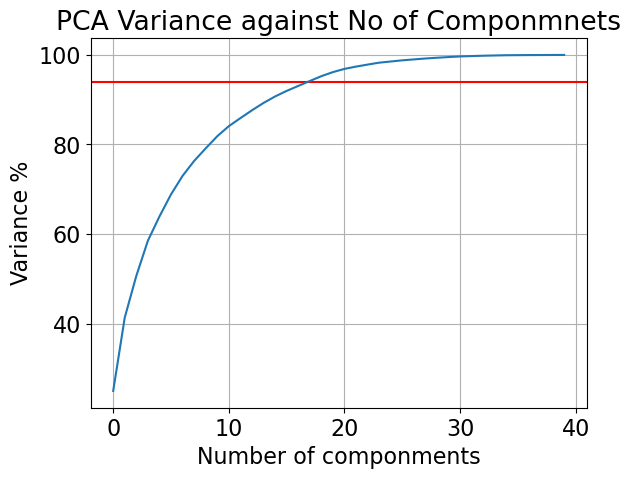

In [51]:
from sklearn.decomposition import PCA

# Dimensionality reduction
pca = PCA()
pca.fit(X_train)
var= pca.explained_variance_ratio_
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

plt.title("PCA Variance against No of Componmnets")
plt.ylabel("Variance %")
plt.xlabel("Number of componments")
l = plt.axhline(94, color="red")

plt.plot(var1)
plt.grid()

#### 6.5. FIT AND TRANSFORM

In [52]:
pca = PCA(n_components=17)
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)

In [53]:
X_test

array([[-1.8422255 ,  1.206574  , -0.93172419, ...,  0.11927172,
         0.3149597 ,  0.87411884],
       [-0.66668057,  0.95155967, -1.17120074, ...,  0.28643672,
        -0.09958614,  0.72665355],
       [-0.2480062 ,  1.18220939, -1.09865895, ...,  0.67903109,
        -0.0118205 ,  0.54076267],
       ...,
       [ 0.1148855 ,  0.14704654, -0.58920761, ...,  0.08606685,
        -0.3249932 , -2.11768586],
       [ 0.06581666,  0.13345155, -0.59711039, ...,  0.05217052,
        -0.30799307, -2.13615978],
       [ 0.06165138,  0.09884246, -0.60783859, ...,  0.08704672,
        -0.32482886, -2.07024368]])

#### 6.6 MODEL SELECTION

In this section, I have employed different classification algorithms and compared them to determine which is the best predictive model for this analysis. The algorithms used are: 
* Logistics Regression
* Random Forest

I first of all define a function to calculate metrics: Accuracy, Precision, Recall and F1 Score to be used for this analysis.

In [54]:
def get_metrics (y_true,y_pred):
    acc = accuracy_score(y_true, y_pred)
    p = precision_score(y_true, y_pred,average=None).mean()
    r = recall_score(y_true, y_pred, average=None).mean()
    f1 = f1_score(y_true, y_pred, average=None).mean()

    print("Accuracy: %.3f \nPrecesion: %.3f \nRecall: %.3f \nF1:%.3f \n"% (acc,p,r,f1) )   

#### 6.6.1 LOGISTICS REGRESSION

The logistic regression is implemented as a linear model for classification rather than regression. It models the probability of an event taking place by having the log-odds for the event be a linear combination of one or more independent variables. I t can be used for both binary and multivariate tasks

In [55]:
# Define model, fit and predict

log_reg = LogisticRegression(solver = 'newton-cg', max_iter=1000, n_jobs = -1, multi_class='multinomial', random_state=0)
log_reg.fit(X_train, y_train )
y_pred = log_reg.predict(X_test)

# Get metrics
get_metrics(y_test, y_pred)

Accuracy: 0.215 
Precesion: 0.207 
Recall: 0.206 
F1:0.178 



#### 6.6.2 RANDOM FOREST CLASSIFIER

A random forest algorithm is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. In random forest, each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. It can be used for both classification and regression which makes it a very versatile algorithm. They provide high accuracy and work well with high dimensional dataset

In [56]:
# Define model, fit and predict

rf = RandomForestClassifier(n_jobs = -1, random_state = 42)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)

# Get metrics
get_metrics(y_test, y_pred_rf)

Accuracy: 0.276 
Precesion: 0.273 
Recall: 0.271 
F1:0.221 



#### 6.7. CROSS VALIDATION

Cross-validation is a resampling method that uses different portions of the data to test and train a model on different iterations. When evaluating different settings for estimators, there is a risk of overfitting on the test. Knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, a part of the dataset can be held out as a “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

The computation of the results for the cell below took a long time because the PC I am using has very little processing power. Because of this, it was submitted without the outputs, but the code is functional and may be run by the examiner for verification.

In [ ]:
# Cross Validate 

classifiers = [LogisticRegression(solver = 'newton-cg', max_iter=1000, n_jobs=-1, multi_class='multinomial', random_state=0),
               RandomForestClassifier(n_jobs =- 1, random_state = 42)]

score_lst = []
for cls in classifiers:
    # cross validate the accurancy
    acc  = accuracy_score(y_train, cross_val_predict(cls, X_train, y_train, cv = 5))
    # calcuate the error
    scores = cross_val_score(cls, X_train, y_train, scoring = "neg_mean_squared_error",cv= 5)
    score = np.sqrt(-scores)
    f1 = cross_val_score(cls,X_test, y_test, scoring = "f1_macro", cv = 5)
    
    score_lst.append([cls.__class__.__name__, acc, score.mean(), f1.mean()])

df_scores=pd.DataFrame(columns = ["Clasifier","Accurancy","MSE","F1"],data =  score_lst)
display(df_scores)

## 7. INTERPRETATION

Accuracy score is the fraction of correct predictions versus the total prediction. Although this metric does not tell us how accurate our model is in predicting (ie: It could predict correctly on just one class with high accuracy). The accuracy score from the predictions of logistic regression and random forest are still quite low. This might be indicative of the fact that the models are failing to predict any class in the dataset.

Precision is the fraction of correct positive prediction. A good precision score should be close to 1.
Recall is the proportion of positive samples correctly classified. It should ideally be close to 1 for a good classifier. 
The Precision and Recall scores from both the logistic and random forest model are also low. This means the models are not predicticting the classes correctly.

The F1 score is the harmonic mean of the precision and recall. Again, for a good classifier, the F1 score should be above 0.5. The score from both of the classifiers are still poor.

## 8. SUMMARY

The result from the modelling shows a very poor performance from our logistics regression and random forest algorithm, suggesting that they did not perform well with the multivarite data. The activity data that was predicted varied in number (1 - 18). It is possible that the algorithm could not properly learn to predict all these classes. A solution to this would be to use grouped activitiy data: Rigorous, Moderate and Light activities for prediction. All the activities should be placed in a matching group and labelled 0, 1, 3 (0 = Light, 1 = Moderate, 2 = Rigorous). The unsupervised learning technique KMeans can be used to cluster the activities into appropriate groups before modelling.

Data Leakage: This is also a potential problem in this analysis. Data leakage is when information from outside the training dataset is used to create the model. It may lead to creating overly optimistic models that are practically useless and cannot be used in production. When the fit_transform method was applied in dimensionality reduction, it is possible that data leakage could have occured at this point. A solution to this would be to put the data in a processing pipeline. This ensures, the algorithm does not access the test data before prediction.

Imbalanced Dataset: The distribution of examples across the class (activityID) labels are not equal. From the analysis, we could see that rigorous activities like rope jumping and running had fewer timstamp (data). The classification models had few examples of these activities to learn from and make accurate prediction. More data for these activities should be provided to improve the model. If more data cannot be accessed, other sampling techniques (over sampling, under sampling) can be employed to artificially generate more data.

Hyperparameter Tuning: A hyperparameter is a parameter whose value is used to control the learning process of an algorithm. They cannot be estimated by the model from given data, rather, they are set manually. The choice of hyperparameter decide how efficient and accurate the optimization process is in estimating parameters. Hyperparameter tuning should be used to determine the right combination of hyperparameters that maximise the model performance. Tuning can be achieved by running multiple trials in a single training process or utilising already existing algorithms (eg: GridSearch) to automate the process. 

More Robost Models: More robost models that can handle multivariate data can employed to improve accuracy. Subject_id = 9 which had very few timesatmps should also be removed as it might introduce error in the analysis. 
The cross validation method cv could also potentially be increased and the best result from the validation should be slected and applied to the test data to improve accuracy.

In [57]:
import io
from nbformat import read
filepath="DSRM-Edna.ipynb"
with io.open(filepath, 'r', encoding='utf-8') as f:
    nb=read(f, 4)
word_count = 0
for cell in nb['cells']:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count))

Submission length is 4002


# REFERENCES

- https://flexbooks.ck12.org/cbook/ck-12-probability-and-statistics-concepts/section/4.6/primary/lesson/interpreting-histograms-pst/
- https://en.wikipedia.org/wiki/Skewness
- https://en.wikipedia.org/wiki/Correlation
- https://en.wikipedia.org/wiki/Logistic_regression
- https://en.wikipedia.org/wiki/Cross-validation_(statistics)
- https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)
- https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler
- https://en.wikipedia.org/wiki/Dimensionality_reduction
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- https://scikit-learn.org/stable/modules/cross_validation.html
- https://github.com/andreasKyratzis/PAMAP2-Physical-Activity-Monitoring-Data-Analysis-and-ML/
- Data Science Researchh Methods, Lab 1 - 8
- Data Science Research Methods, Lecture slides